In [1]:
import os
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import findfont, FontProperties
import os, sys, pathlib
from pathlib import Path
import pandas as pd
from shapely.geometry import Point, box
import contextily as ctx

In [2]:
print("CWD:", os.getcwd())

CWD: C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\2nd-paper\phd_ppr2


In [3]:
# Example absolute path: include the drive letter and the OneDrive folder
shp_path = Path(r"C:\Users\...\PPR1_Map_Data\SHAPEFILES\snp_border_lv95.shp")

print("Exists?", shp_path.exists())
# print("Parent contents:", list(shp_path.parent.glob("snp_border_lv95.*")))

Exists? True


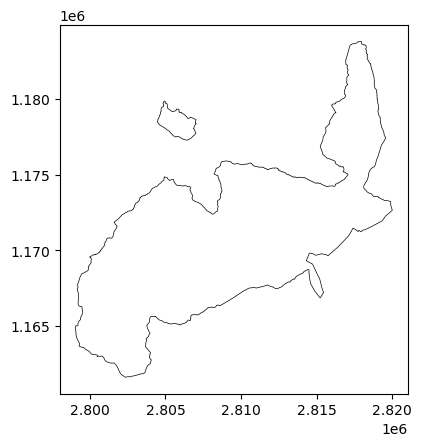

In [49]:
# Read shapefile
swiss = gpd.read_file(shp_path)

# Reproject to EPSG:2056 if needed
if swiss.crs != "EPSG:2056":
    swiss = swiss.to_crs("EPSG:2056")
    
# Plot shapefile over raster
ax = swiss.plot(facecolor="none", edgecolor="black", linewidth=0.5)

In [50]:
CRS_TARGET = "EPSG:2056"

# -----------------------
# 1) Load Swiss NP boundary
# -----------------------
SHP_SNP = Path(r"C:\Users\...\PPR1_Map_Data\SHAPEFILES\snp_border_lv95.shp")
snp = gpd.read_file(SHP_SNP)
if snp.crs is None:
    snp = snp.set_crs(CRS_TARGET)
elif snp.crs.to_string() != CRS_TARGET:
    snp = snp.to_crs(CRS_TARGET)

# -----------------------
# 2) Load land-cover layers (rock/grassland/forest)
#     (Edit the paths; all sidecar files must be in same folder)
# -----------------------
SHP_ROCK      = Path("PPR1_Map_Data/SHAPEFILES/.../Habitalp_SNP_rock_fit.shp")
SHP_GRASSLAND = Path("PPR1_Map_Data/SHAPEFILES/.../Habitalp_SNP_grassland_fit.shp")
SNP_SCHREE    = Path("PPR1_Map_Data/SHAPEFILES/.../Habitalp_SNP_schree_fit.shp")
SHP_FOREST    = Path("PPR1_Map_Data/SHAPEFILES/.../Habitalp_SNP_forest_fitt.shp")
                     
def load_to_2056(path: Path) -> gpd.GeoDataFrame:
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_TARGET)   # set only if you KNOW it's already 2056
    elif gdf.crs.to_string() != CRS_TARGET:
        gdf = gdf.to_crs(CRS_TARGET)
    return gdf

rock      = load_to_2056(SHP_ROCK)
grassland = load_to_2056(SHP_GRASSLAND)
forest    = load_to_2056(SHP_FOREST)
schree    = load_to_2056(SNP_SCHREE)

In [51]:
# -----------------------
# 3) Load point CSVs (2010, 2012, 2013) -> GeoDataFrames
#     Adjust CRS below if CSVs are lon/lat (EPSG:4326).
# -----------------------
CSV_2010 = Path("PPR1_Map_Data/No_Duplicates_Processing_1_Model_input_2010_REF_INTERPOLATED_with_Metadata_Plots_All-Accurate.csv")
CSV_2012 = Path("PPR1_Map_Data/No_Duplicates_Processing_1_Model_input_2012_REF_INTERPOLATED_with_Metadata_Plots_All-Accurate.csv")
CSV_2013 = Path("PPR1_Map_Data/No_Duplicates_Processing_1_Model_input_2013_REF_INTERPOLATED_with_Metadata_Plots_All-Accurate.csv")
CSV_CRS  = "EPSG:2056"  # change to "EPSG:4326" if your CSVs are lon/lat

X_CANDS = ["X_east"]
Y_CANDS = ["Y_north"]

def csv_points_to_gdf(csv_path: Path, src_crs: str) -> gpd.GeoDataFrame:
    df = pd.read_csv(csv_path)
    x_col = next((c for c in X_CANDS if c in df.columns), None)
    y_col = next((c for c in Y_CANDS if c in df.columns), None)
    if x_col is None or y_col is None:
        raise ValueError(f"Could not find coordinate columns in {csv_path.name}. "
                         f"Tried X={X_CANDS}, Y={Y_CANDS}. Columns: {list(df.columns)}")
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df[x_col], df[y_col])],
        crs=src_crs
    )
    if gdf.crs.to_string() != CRS_TARGET:
        gdf = gdf.to_crs(CRS_TARGET)
    return gdf

pts2010 = csv_points_to_gdf(CSV_2010, CSV_CRS); pts2010["year"] = 2010
pts2012 = csv_points_to_gdf(CSV_2012, CSV_CRS); pts2012["year"] = 2012
pts2013 = csv_points_to_gdf(CSV_2013, CSV_CRS); pts2013["year"] = 2013

# Combine all points (for AOI creation & quick plotting)
pts_all = pd.concat([pts2010, pts2012, pts2013], ignore_index=True)
pts_all = gpd.GeoDataFrame(pts_all, geometry="geometry", crs=CRS_TARGET)

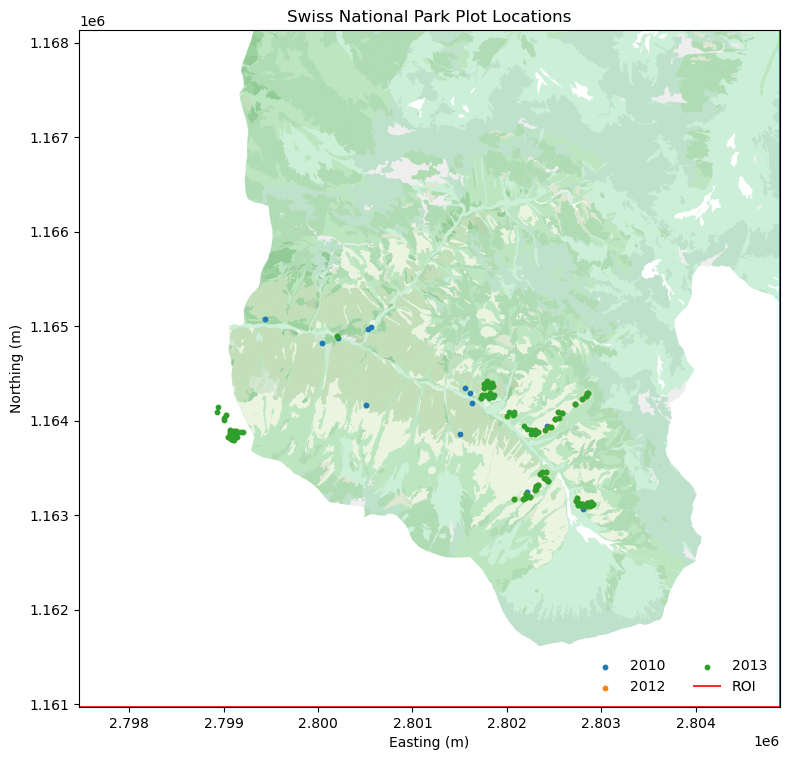

In [54]:
# -----------------------
# 5) Quick map to verify
# -----------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Optional draw order: landcovers first
if not rock.empty:      rock.plot(ax=ax, facecolor="#aaaaaa", edgecolor="none", alpha=0.2, label="Rock")
if not grassland.empty: grassland.plot(ax=ax, facecolor="#99cc66", edgecolor="none", alpha=0.2, label="Grassland")
if not schree.empty: schree.plot(ax=ax, facecolor="#00B140", edgecolor="none", alpha=0.2, label="Schree")
if not forest.empty:    forest.plot(ax=ax, facecolor="#228B22", edgecolor="none", alpha=0.2, label="Forest")

# SNP boundary on top
# snp.boundary.plot(ax=ax, color="black", linewidth=0.8, label="SNP boundary")

# Points by year
(pts2010.plot(ax=ax, color="tab:blue",  markersize=10, label="2010"))
(pts2012.plot(ax=ax, color="tab:orange", markersize=10, label="2012"))
(pts2013.plot(ax=ax, color="tab:green", markersize=10, label="2013"))

# AOI rectangle outline
aoi_pathi = Path(r"C:\Users\...\PPR1_Maps\mosaic_extent_rect_EPSG2056.shp")
Swiss_shp = Path(r"C:\Users\...\PPR1_Maps\Switzerland_Shapefile.shp")
Swiss_geo = Path(r"C:\Users\...\PPR1_Maps\swissaltiregio_2056_5728.tif") #swiss-map-raster1000_1000_krel_50_2056.tif")
snp = gpd.read_file(aoi_pathi)
snp.boundary.plot(ax=ax, color="red", linewidth=1.2, label="ROI")
# snp = gpd.read_file(Swiss_shp)
# snp.boundary.plot(ax=ax, color="blue", linewidth=1, label="ROI")


ax.set_title("Swiss National Park Plot Locations")
ax.set_xlabel("Easting (m)"); ax.set_ylabel("Northing (m)")
ax.legend(frameon=False, ncol=2, loc="lower right")
# ax = snp.boundary.plot(figsize=(8,8), edgecolor="black")
# pts_all.plot(ax=ax, color="red", markersize=20)
# ctx.add_basemap(ax, crs=snp.crs.to_string(), source=ctx.providers.OpenTopoMap)

ax.set_xlim(snp.total_bounds[0], snp.total_bounds[2])
ax.set_ylim(snp.total_bounds[1], snp.total_bounds[3])

plt.tight_layout()
plt.show()

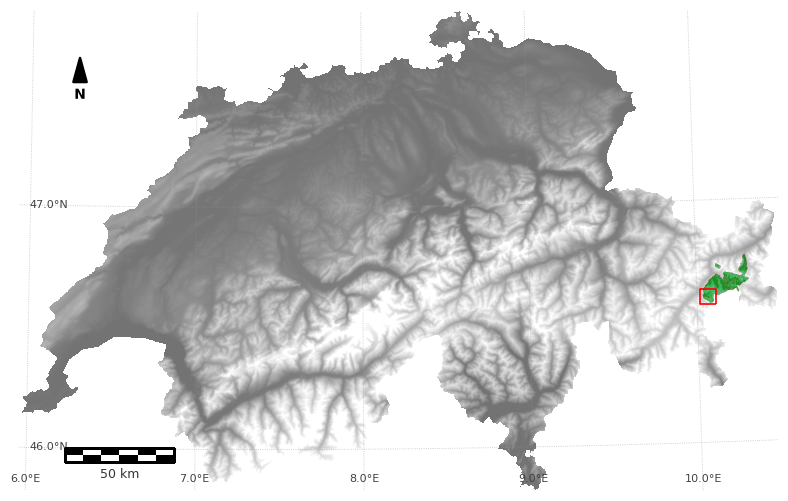

In [70]:
# --- Offline, pale-grayscale DEM background (masked to Switzerland), no labels ---

import numpy as np
import geopandas as gpd
import rasterio, rasterio.mask
from affine import Affine
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.ops import unary_union
from matplotlib.patches import FancyArrow
import matplotlib.patheffects as pe
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from pyproj import Transformer

# ========= PATHS (ADJUST HERE) =========
Swiss_geo = Path(r"C:\Users\...\PPR1_Maps\swissaltiregio_2056_5728.tif")
Swiss_shp = Path(r"C:\Users\...\PPR1_Maps\Switzerland_Shapefile.shp")
PARK_SHP  = Path(r"C:\Users\...\PPR1_Map_Data\SHAPEFILES\snp_border_lv95.shp")
AOI_SHP   = Path(r"C:\Users\...\PPR1_Maps\mosaic_extent_rect_EPSG2056.shp")  # optional ROI box
CRS = "EPSG:2056"
# ======================================

# ====== DEM DISPLAY / SPEED CONTROLS ======
PCT_MIN, PCT_MAX = 3, 97     # ADJUST HERE → DEM contrast (percentile stretch)
IMG_ALPHA = 0.55             # ADJUST HERE → DEM paleness (lower = paler)
MAX_PIXELS = 6_000_000       # ADJUST HERE → cap displayed pixels (None = full-res)
PAD = 5                      # ADJUST HERE → view padding (meters)
INTERP = "bilinear"          # ADJUST HERE → "nearest" or "bilinear"
# ==========================================

# ====== PARK STYLE TOGGLES & KNOBS ======
SHOW_PARK_FILL   = True      # ADJUST HERE → show/hide park fill
SHOW_PARK_BORDER = False     # ADJUST HERE → show/hide park border
FILL_MERGE       = False     # ADJUST HERE → try merging fill into one polygon (can be slow/fragile). False = robust

LINE_W     = 2.0             # If SHOW_PARK_BORDER=True
# LINE_COL   = "red"
# FILL_COL   = "red"
FILL_ALPHA = 0.35
BUF_M      = 50              # If PARK_SHP is lines: buffer width (m) to create a fill area
# ========================================

def add_north_triangle(
    ax, extent,
    size_frac=0.06,   # ADJUST HERE → triangle height as fraction of min(map width, height)
    x_frac=0.08,      # ADJUST HERE → horizontal position from left (0..1)
    y_frac=0.10,      # ADJUST HERE → vertical position from top (0..1)
    facecolor="black",# ADJUST HERE → triangle fill color ("none" for hollow)
    edgecolor="black",# ADJUST HERE → triangle outline color
    linewidth=1.6,    # ADJUST HERE → outline thickness
    alpha=1.0,        # ADJUST HERE → triangle transparency (0..1)
    base_width=0.55,  # ADJUST HERE → base width relative to triangle height (0.4–0.8 works well)
    label="N",        # ADJUST HERE → label text (set None to hide)
    label_pad_frac=0.012, # ADJUST HERE → gap between triangle base and label (fraction of map height)
    label_size=None,  # ADJUST HERE → None = auto; or set a number (e.g., 12)
    zorder=1000
):
    """
    Draw a small isosceles triangle pointing north (up), with an optional 'N' label below.
    extent = (xmin, xmax, ymin, ymax) in EPSG:2056.
    """
    xmin, xmax, ymin, ymax = extent
    W = xmax - xmin
    H = ymax - ymin

    # Position near top-left by default
    x = xmin + x_frac * W
    y = ymax - y_frac * H

    # Triangle geometry in data units
    L = size_frac * min(W, H)             # triangle height
    half_base = (base_width * L) / 2.0    # half of base width
    apex = (x, y)                         # top vertex (points north)
    left_base  = (x - half_base, y - L)
    right_base = (x + half_base, y - L)

    tri = Polygon([apex, left_base, right_base],
                  closed=True, facecolor=facecolor, edgecolor=edgecolor,
                  linewidth=linewidth, alpha=alpha, joinstyle="round")
    ax.add_patch(tri)

    # Label below the base
    if label:
        if label_size is None:
            label_size = max(8, int(7 + 70 * size_frac))  # simple auto scaling
        tx = x
        ty = (y - L) - label_pad_frac * H
        txt = ax.text(tx, ty, label,
                      ha="center", va="top",
                      fontsize=label_size, color=edgecolor, fontweight="bold",
                      zorder=zorder + 1)
        # White halo for contrast
        txt.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])

    return tri


def add_checker_scalebar(
    ax, extent,
    meters=50_000,       # << ADJUST: total bar length (e.g., 20_000, 50_000, 100_000)
    segments=6,         # << ADJUST: blocks per row (use even numbers: 6, 8, 10…)
    pad_frac=0.06,       # position from left/bottom (fraction of map size)
    height_frac=0.015,    # bar row height (fraction of map height)
    gap_frac= 0 , # 0.004,      # small gap between the two rows
    edgecolor= "0" , #"0.3",     # thin outer outline color
    zorder=2000,
    label=None,          # e.g., "50 km" — or leave None for no text
    text_pad_frac=0.012,
    text_kwargs=None
):
    xmin, xmax, ymin, ymax = extent
    W = xmax - xmin; H = ymax - ymin

    # keep bar inside the frame
    meters = min(meters, 0.9*W)

    x0 = xmin + pad_frac*W
    y0 = ymin + pad_frac*H
    h  = height_frac*H
    gap = gap_frac*H
    seg_w = meters / int(segments)

    # top row (starts black), bottom row (starts white)
    for row in (1, 0):
        y = y0 + row*(h + gap)
        for i in range(int(segments)):
            is_black = (i % 2 == 0) if row == 1 else (i % 2 == 1)
            ax.add_patch(Rectangle(
                (x0 + i*seg_w, y), seg_w, h,
                facecolor=("k" if is_black else "w"),
                edgecolor="none", linewidth=0, antialiased=False,
                zorder=zorder
            ))

    # outer outline
    ax.add_patch(Rectangle(
        (x0, y0), meters, 2*h + gap,
        facecolor="none", edgecolor=edgecolor, linewidth=0.9,
        joinstyle="miter", antialiased=False, zorder=zorder+1
    ))

    if label:
        if text_kwargs is None:
            text_kwargs = dict(fontsize=9, color="0.2")
        ax.text(x0 + meters/2, y0 - text_pad_frac*H, label,
                ha="center", va="top", zorder=zorder+2, **text_kwargs)

def add_lonlat_graticule(
    ax, extent,
    spacing_deg=None,                 # ADJUST → 1.0, 0.5, 0.25 …; None = auto
    line_kw=None,                     # ADJUST → dict(color, linewidth, linestyle, alpha)
    text_kw=None,                     # ADJUST → dict(fontsize, color)
    crs_map="EPSG:2056",
    pad_frac=0.002,                   # ADJUST → label inset from edges (fraction of width/height)
    npts=200,                         # sampling density per line
    z_line=120, z_text=121
):
    """
    Draw meridians & parallels that fall *inside* the current map extent.
    Labels are placed just inside the bottom/left edges.
    """
    xmin, xmax, ymin, ymax = extent
    W, H = (xmax - xmin), (ymax - ymin)

    # defaults
    if line_kw is None:
        line_kw = dict(color="0.5", linewidth=0.6, linestyle=":", alpha=0.7)
    if text_kw is None:
        text_kw = dict(color="0.25", fontsize=8)

    to_geo = Transformer.from_crs(crs_map, "EPSG:4326", always_xy=True)
    to_map = Transformer.from_crs("EPSG:4326", crs_map, always_xy=True)

    # geographic bounds from the four corners (fast & stable)
    xc = np.array([xmin, xmax, xmax, xmin])
    yc = np.array([ymin, ymin, ymax, ymax])
    lonc, latc = to_geo.transform(xc, yc)
    lon_min, lon_max = float(np.nanmin(lonc)), float(np.nanmax(lonc))
    lat_min, lat_max = float(np.nanmin(latc)), float(np.nanmax(latc))

    # choose a nice spacing if not given
    if spacing_deg is None:
        span = max(lon_max - lon_min, lat_max - lat_min)
        spacing = 1.0 if span > 4 else 0.5 if span > 2 else 0.25
    else:
        spacing = float(spacing_deg)

    # build values strictly inside the geo extent
    lon_start = np.ceil(lon_min / spacing) * spacing
    lon_end   = np.floor(lon_max / spacing) * spacing
    lat_start = np.ceil(lat_min / spacing) * spacing
    lat_end   = np.floor(lat_max / spacing) * spacing
    lons = np.arange(lon_start, lon_end + 1e-9, spacing)
    lats = np.arange(lat_start, lat_end + 1e-9, spacing)

    # helper to clip plotted lines to the axes patch
    def _clip_last(lines):
        for ln in lines:
            ln.set_clip_on(True)
            ln.set_clip_path(ax.patch)

    # meridians
    for lo in lons:
        lat_line = np.linspace(lat_min, lat_max, npts)
        lon_line = np.full_like(lat_line, lo)
        x_line, y_line = to_map.transform(lon_line, lat_line)
        _clip_last(ax.plot(x_line, y_line, zorder=z_line, **line_kw))

        # bottom label (nudged inside the frame)
        xb, _ = to_map.transform([lo], [lat_min])
        ax.text(
            xb[0], ymin + pad_frac * H,
            f"{abs(lo):.1f}°E" if lo >= 0 else f"{abs(lo):.1f}°W",
            ha="center", va="bottom", zorder=z_text, **text_kw
        )

    # parallels
    for la in lats:
        lon_line = np.linspace(lon_min, lon_max, npts)
        lat_line = np.full_like(lon_line, la)
        x_line, y_line = to_map.transform(lon_line, lat_line)
        _clip_last(ax.plot(x_line, y_line, zorder=z_line, **line_kw))

        # left label (nudged inside the frame)
        xl, _ = to_map.transform([lon_min], [la])
        ax.text(
            xmin + pad_frac * W, y_line.mean(),    # center-ish along left edge
            f"{abs(la):.1f}°N" if la >= 0 else f"{abs(la):.1f}°S",
            ha="left", va="center", zorder=z_text, **text_kw
        )
        
        
# ========================================

# -- Load borders
swiss = gpd.read_file(Swiss_shp)
if swiss.crs is None or swiss.crs.to_string() != CRS:
    swiss = swiss.to_crs(CRS)
swiss_union = unary_union(swiss.geometry.buffer(0))  # robust union

park = gpd.read_file(PARK_SHP)
if park.crs is None or park.crs.to_string() != CRS:
    park = park.to_crs(CRS)

# Optional ROI (will plot if file exists)
roi = None
if AOI_SHP.exists():
    roi = gpd.read_file(AOI_SHP)
    if roi.crs is None or roi.crs.to_string() != CRS:
        roi = roi.to_crs(CRS)

# -- Figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("white")

# -------- Optional layers you had (only if defined) --------
def _maybe_plot(gdf, **kw):
    try:
        if isinstance(gdf, gpd.GeoDataFrame) and (not gdf.empty):
            gdf.plot(ax=ax, **kw)
    except NameError:
        pass

_maybe_plot(globals().get("rock"),      facecolor="#aaaaaa", edgecolor="none", alpha=0.8, label="Rock")
_maybe_plot(globals().get("grassland"), facecolor="#99cc66", edgecolor="none", alpha=0.8, label="Grassland")
_maybe_plot(globals().get("schree"),    facecolor="#00B140", edgecolor="none", alpha=0.8, label="Schree")
_maybe_plot(globals().get("forest"),    facecolor="#228B22", edgecolor="none", alpha=0.8, label="Forest")
# -----------------------------------------------------------

# -- Mask DEM to Switzerland and draw
with rasterio.open(Swiss_geo) as src:
    if src.crs is None or src.crs.to_string() != CRS:
        raise ValueError(f"DEM CRS is {src.crs}, expected {CRS}")

    out_img, out_trans = rasterio.mask.mask(src, [swiss_union], crop=True, filled=False)
    dem = out_img[0]  # masked array

    # Downsample for speed if needed
    h, w = dem.shape
    step = 1
    if MAX_PIXELS is not None and (h * w) > MAX_PIXELS:
        step = int(np.ceil(np.sqrt((h * w) / MAX_PIXELS)))  # ↑ increase for faster/coarser
    if step > 1:
        dem = dem[::step, ::step]
        out_trans = out_trans * Affine.scale(step, step)

    height, width = dem.shape
    xmin = out_trans.c
    ymax = out_trans.f
    xmax = xmin + out_trans.a * width
    ymin = ymax + out_trans.e * height
    extent = (xmin, xmax, ymin, ymax)

    dem_f = dem.filled(np.nan)
    vmin = np.nanpercentile(dem_f, PCT_MIN)
    vmax = np.nanpercentile(dem_f, PCT_MAX)

    ax.imshow(
        dem, extent=extent, origin="upper",
        cmap="gray", vmin=vmin, vmax=vmax, alpha=IMG_ALPHA,
        interpolation=INTERP
    )

# --- Overlays (draw AFTER the raster so they sit on top) ---
# Optional Switzerland border (0 width = hidden)
swiss.boundary.plot(ax=ax, color="black", linewidth=0, zorder=10)

# Optional ROI rectangle
if roi is not None:
    roi.boundary.plot(ax=ax, color="red", linewidth=1.2, zorder=950)

# Park: polygons vs lines vs points (controlled by SHOW_PARK_FILL / SHOW_PARK_BORDER)
gtypes = set(park.geom_type.unique())

if gtypes <= {"Polygon", "MultiPolygon"}:
    park_poly = park.dissolve()

    # Fill
    if SHOW_PARK_FILL:
        park_poly.plot(ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA,
                       edgecolor="none", linewidth=0, zorder=998)

    # Border
    if SHOW_PARK_BORDER:
        park_poly.boundary.plot(ax=ax, color=LINE_COL, linewidth=LINE_W,
                                linestyle="-", zorder=999, capstyle="round", joinstyle="round")

elif gtypes <= {"LineString", "MultiLineString"}:
    # Fill via buffer
    if SHOW_PARK_FILL:
        buf_series = park.buffer(BUF_M)  # GeoSeries of buffered polygons

        if FILL_MERGE:
            # Try to merge in chunks to avoid GEOS recursion/stack overflow
            try:
                geoms = list(buf_series.values)
                CHUNK = 2000  # ADJUST HERE if needed
                parts = []
                for i in range(0, len(geoms), CHUNK):
                    parts.append(unary_union(geoms[i:i+CHUNK]))
                merged = unary_union(parts)
                gpd.GeoSeries([merged], crs=park.crs).plot(
                    ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
                )
            except Exception as e:
                print(f"⚠️ Merge failed ({e}). Drawing unmerged buffers instead.")
                gpd.GeoSeries(buf_series, crs=park.crs).plot(
                    ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
                )
        else:
            # Fast & robust: draw unmerged buffers (no union)
            gpd.GeoSeries(buf_series, crs=park.crs).plot(
                ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
            )

    # Border
    if SHOW_PARK_BORDER:
        park_line = park.dissolve()
        park_line.plot(ax=ax, color=LINE_COL, linewidth=LINE_W, linestyle="-",
                       zorder=999, capstyle="round", joinstyle="round")

else:
    # Points: fill not applicable
    if SHOW_PARK_BORDER:
        park.plot(ax=ax, color=LINE_COL, markersize=6, zorder=999)
        print("⚠️ PARK_SHP contains POINT geometries. Use polygon/line data to enable fill.")

# -- View: only Switzerland shown; outside is white
minx, miny, maxx, maxy = swiss.total_bounds
ax.set_xlim(minx - PAD, maxx + PAD)
ax.set_ylim(miny - PAD, maxy + PAD)

# Add north arrow (uses the same 'extent' you computed for imshow)
add_north_triangle(
    ax, extent,
    size_frac=0.05,    # overall size
    x_frac=0.08,       # move left/right
    y_frac=0.10,       # move down from top
    facecolor="black", # use "none" for hollow triangle
    edgecolor="black",
    linewidth=1.8,
    label="N"          # set to None to hide the label
)

# Switzerland is ~350 km wide → 50 km bar looks right
add_checker_scalebar(
    ax, extent,
    meters=50_000,   # try 20_000, 50_000, or 100_000
    segments=6,     # even number
    label= "50 km" #None       # or "50 km" if you want text
)

add_lonlat_graticule(
    ax, extent,
    spacing_deg=1.0,  # try 1.0 or 0.5
    line_kw=dict(color="0.6", linewidth=0.6, linestyle=":", alpha=0.6),
    text_kw=dict(color="0.25", fontsize=8),
    pad_frac=0.014
)

# -- Clean map (no labels, no ticks, no legend)
ax.set_axis_off()
plt.tight_layout()
plt.show()


✅ Saved high-res outputs:
- C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\3rd revisions\RSASE_revision_NR-formatting\PPR1_Maps\final_map.png
- C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\3rd revisions\RSASE_revision_NR-formatting\PPR1_Maps\final_map.pdf


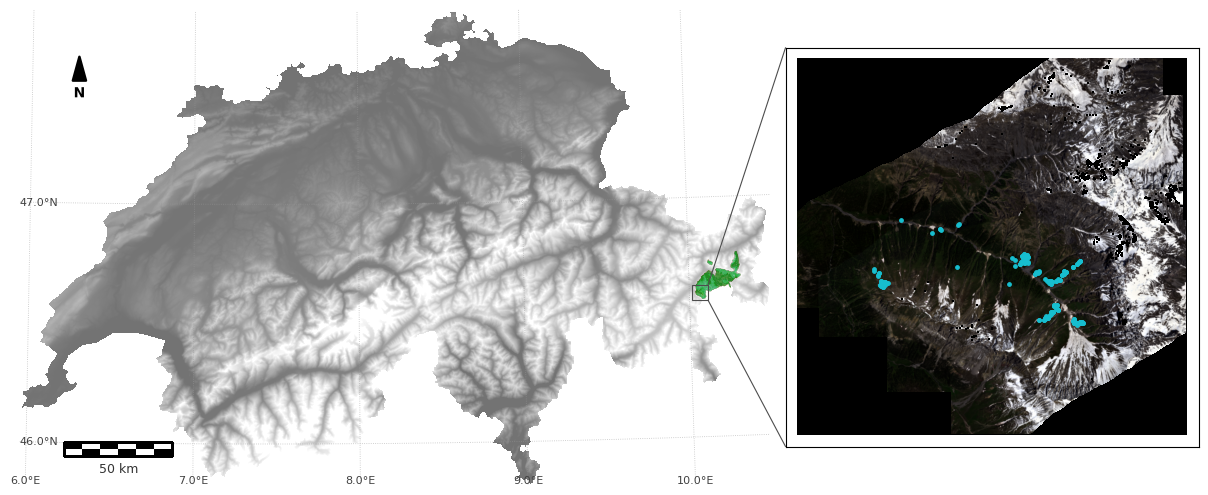

In [94]:
# --- Offline, pale-grayscale DEM background (masked to Switzerland), no labels ---

import numpy as np
import geopandas as gpd
import rasterio, rasterio.mask
from affine import Affine
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.ops import unary_union
from matplotlib.patches import FancyArrow
import matplotlib.patheffects as pe
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from pyproj import Transformer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch

# ========= PATHS (ADJUST HERE) =========
Swiss_geo = Path(r"C:\Users\...\PPR1_Maps\swissaltiregio_2056_5728.tif")
Swiss_shp = Path(r"C:\Users\...\PPR1_Maps\Switzerland_Shapefile.shp")
PARK_SHP  = Path(r"C:\Users\...\PPR1_Map_Data\SHAPEFILES\snp_border_lv95.shp")
AOI_SHP   = Path(r"C:\Users\...\PPR1_Maps\mosaic_extent_rect_EPSG2056.shp")  # optional ROI box
CRS = "EPSG:2056"
# ======================================

# ====== DEM DISPLAY / SPEED CONTROLS ======
PCT_MIN, PCT_MAX = 3, 97     # ADJUST HERE → DEM contrast (percentile stretch)
IMG_ALPHA = 0.55             # ADJUST HERE → DEM paleness (lower = paler)
MAX_PIXELS = 6_000_000       # ADJUST HERE → cap displayed pixels (None = full-res)
PAD = 5                      # ADJUST HERE → view padding (meters)
INTERP = "bilinear"          # ADJUST HERE → "nearest" or "bilinear"
# ==========================================

# ====== PARK STYLE TOGGLES & KNOBS ======
SHOW_PARK_FILL   = True      # ADJUST HERE → show/hide park fill
SHOW_PARK_BORDER = False     # ADJUST HERE → show/hide park border
FILL_MERGE       = False     # ADJUST HERE → try merging fill into one polygon (can be slow/fragile). False = robust

LINE_W     = 2.0             # If SHOW_PARK_BORDER=True
# LINE_COL   = "red"
# FILL_COL   = "red"
FILL_ALPHA = 0.35
BUF_M      = 50              # If PARK_SHP is lines: buffer width (m) to create a fill area
# ========================================

def add_north_triangle(
    ax, extent,
    size_frac=0.06,   # ADJUST HERE → triangle height as fraction of min(map width, height)
    x_frac=0.08,      # ADJUST HERE → horizontal position from left (0..1)
    y_frac=0.10,      # ADJUST HERE → vertical position from top (0..1)
    facecolor="black",# ADJUST HERE → triangle fill color ("none" for hollow)
    edgecolor="black",# ADJUST HERE → triangle outline color
    linewidth=1.6,    # ADJUST HERE → outline thickness
    alpha=1.0,        # ADJUST HERE → triangle transparency (0..1)
    base_width=0.55,  # ADJUST HERE → base width relative to triangle height (0.4–0.8 works well)
    label="N",        # ADJUST HERE → label text (set None to hide)
    label_pad_frac=0.012, # ADJUST HERE → gap between triangle base and label (fraction of map height)
    label_size=None,  # ADJUST HERE → None = auto; or set a number (e.g., 12)
    zorder=1000
):
    """
    Draw a small isosceles triangle pointing north (up), with an optional 'N' label below.
    extent = (xmin, xmax, ymin, ymax) in EPSG:2056.
    """
    xmin, xmax, ymin, ymax = extent
    W = xmax - xmin
    H = ymax - ymin

    # Position near top-left by default
    x = xmin + x_frac * W
    y = ymax - y_frac * H

    # Triangle geometry in data units
    L = size_frac * min(W, H)             # triangle height
    half_base = (base_width * L) / 2.0    # half of base width
    apex = (x, y)                         # top vertex (points north)
    left_base  = (x - half_base, y - L)
    right_base = (x + half_base, y - L)

    tri = Polygon([apex, left_base, right_base],
                  closed=True, facecolor=facecolor, edgecolor=edgecolor,
                  linewidth=linewidth, alpha=alpha, joinstyle="round")
    ax.add_patch(tri)

    # Label below the base
    if label:
        if label_size is None:
            label_size = max(8, int(7 + 70 * size_frac))  # simple auto scaling
        tx = x
        ty = (y - L) - label_pad_frac * H
        txt = ax.text(tx, ty, label,
                      ha="center", va="top",
                      fontsize=label_size, color=edgecolor, fontweight="bold",
                      zorder=zorder + 1)
        # White halo for contrast
        txt.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])

    return tri


def add_checker_scalebar(
    ax, extent,
    meters=50_000,       # << ADJUST: total bar length (e.g., 20_000, 50_000, 100_000)
    segments=6,         # << ADJUST: blocks per row (use even numbers: 6, 8, 10…)
    pad_frac=0.06,       # position from left/bottom (fraction of map size)
    height_frac=0.015,    # bar row height (fraction of map height)
    gap_frac= 0 , # 0.004,      # small gap between the two rows
    edgecolor= "0" , #"0.3",     # thin outer outline color
    zorder=2000,
    label=None,          # e.g., "50 km" — or leave None for no text
    text_pad_frac=0.012,
    text_kwargs=None
):
    xmin, xmax, ymin, ymax = extent
    W = xmax - xmin; H = ymax - ymin

    # keep bar inside the frame
    meters = min(meters, 0.9*W)

    x0 = xmin + pad_frac*W
    y0 = ymin + pad_frac*H
    h  = height_frac*H
    gap = gap_frac*H
    seg_w = meters / int(segments)

    # top row (starts black), bottom row (starts white)
    for row in (1, 0):
        y = y0 + row*(h + gap)
        for i in range(int(segments)):
            is_black = (i % 2 == 0) if row == 1 else (i % 2 == 1)
            ax.add_patch(Rectangle(
                (x0 + i*seg_w, y), seg_w, h,
                facecolor=("k" if is_black else "w"),
                edgecolor="none", linewidth=0, antialiased=False,
                zorder=zorder
            ))

    # outer outline
    ax.add_patch(Rectangle(
        (x0, y0), meters, 2*h + gap,
        facecolor="none", edgecolor=edgecolor, linewidth=0.9,
        joinstyle="miter", antialiased=False, zorder=zorder+1
    ))

    if label:
        if text_kwargs is None:
            text_kwargs = dict(fontsize=9, color="0.2")
        ax.text(x0 + meters/2, y0 - text_pad_frac*H, label,
                ha="center", va="top", zorder=zorder+2, **text_kwargs)

def add_lonlat_graticule(
    ax, extent,
    spacing_deg= 1.5, #None,                 # ADJUST → 1.0, 0.5, 0.25 …; None = auto
    line_kw=None,                     # ADJUST → dict(color, linewidth, linestyle, alpha)
    text_kw=None,                     # ADJUST → dict(fontsize, color)
    crs_map="EPSG:2056",
    pad_frac=0.002,                   # ADJUST → label inset from edges (fraction of width/height)
    npts=200,                         # sampling density per line
    z_line=120, z_text=121
):
    """
    Draw meridians & parallels that fall *inside* the current map extent.
    Labels are placed just inside the bottom/left edges.
    """
    xmin, xmax, ymin, ymax = extent
    W, H = (xmax - xmin), (ymax - ymin)

    # defaults
    if line_kw is None:
        line_kw = dict(color="0.5", linewidth=0.6, linestyle=":", alpha=0.7)
    if text_kw is None:
        text_kw = dict(color="0.25", fontsize=8)

    to_geo = Transformer.from_crs(crs_map, "EPSG:4326", always_xy=True)
    to_map = Transformer.from_crs("EPSG:4326", crs_map, always_xy=True)

    # geographic bounds from the four corners (fast & stable)
    xc = np.array([xmin, xmax, xmax, xmin])
    yc = np.array([ymin, ymin, ymax, ymax])
    lonc, latc = to_geo.transform(xc, yc)
    lon_min, lon_max = float(np.nanmin(lonc)), float(np.nanmax(lonc))
    lat_min, lat_max = float(np.nanmin(latc)), float(np.nanmax(latc))

    # choose a nice spacing if not given
    if spacing_deg is None:
        span = max(lon_max - lon_min, lat_max - lat_min)
        spacing = 1.0 if span > 4 else 0.5 if span > 2 else 0.25
    else:
        spacing = float(spacing_deg)

    # build values strictly inside the geo extent
    lon_start = np.ceil(lon_min / spacing) * spacing
    lon_end   = np.floor(lon_max / spacing) * spacing
    lat_start = np.ceil(lat_min / spacing) * spacing
    lat_end   = np.floor(lat_max / spacing) * spacing
    lons = np.arange(lon_start, lon_end + 1e-9, spacing)
    lats = np.arange(lat_start, lat_end + 1e-9, spacing)

    # helper to clip plotted lines to the axes patch
    def _clip_last(lines):
        for ln in lines:
            ln.set_clip_on(True)
            ln.set_clip_path(ax.patch)

    # meridians
    for lo in lons:
        lat_line = np.linspace(lat_min, lat_max, npts)
        lon_line = np.full_like(lat_line, lo)
        x_line, y_line = to_map.transform(lon_line, lat_line)
        _clip_last(ax.plot(x_line, y_line, zorder=z_line, **line_kw))

        # bottom label (nudged inside the frame)
        xb, _ = to_map.transform([lo], [lat_min])
        ax.text(
            xb[0], ymin + pad_frac * H,
            f"{abs(lo):.1f}°E" if lo >= 0 else f"{abs(lo):.1f}°W",
            ha="center", va="bottom", zorder=z_text, **text_kw
        )

    # parallels
    for la in lats:
        lon_line = np.linspace(lon_min, lon_max, npts)
        lat_line = np.full_like(lon_line, la)
        x_line, y_line = to_map.transform(lon_line, lat_line)
        _clip_last(ax.plot(x_line, y_line, zorder=z_line, **line_kw))

        # left label (nudged inside the frame)
        xl, _ = to_map.transform([lon_min], [la])
        ax.text(
            xmin + pad_frac * W, y_line.mean(),    # center-ish along left edge
            f"{abs(la):.1f}°N" if la >= 0 else f"{abs(la):.1f}°S",
            ha="left", va="center", zorder=z_text, **text_kw
        )
        
        
# ========================================

# -- Load borders
swiss = gpd.read_file(Swiss_shp)
if swiss.crs is None or swiss.crs.to_string() != CRS:
    swiss = swiss.to_crs(CRS)
swiss_union = unary_union(swiss.geometry.buffer(0))  # robust union

park = gpd.read_file(PARK_SHP)
if park.crs is None or park.crs.to_string() != CRS:
    park = park.to_crs(CRS)

# # Optional ROI (will plot if file exists)
# roi = None
# if AOI_SHP.exists():
#     roi = gpd.read_file(AOI_SHP)
#     if roi.crs is None or roi.crs.to_string() != CRS:
#         roi = roi.to_crs(CRS)

# -- Figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("white")

# -------- Optional layers you had (only if defined) --------
def _maybe_plot(gdf, **kw):
    try:
        if isinstance(gdf, gpd.GeoDataFrame) and (not gdf.empty):
            gdf.plot(ax=ax, **kw)
    except NameError:
        pass

_maybe_plot(globals().get("rock"),      facecolor="#aaaaaa", edgecolor="none", alpha=0.8, label="Rock")
_maybe_plot(globals().get("grassland"), facecolor="#99cc66", edgecolor="none", alpha=0.8, label="Grassland")
_maybe_plot(globals().get("schree"),    facecolor="#00B140", edgecolor="none", alpha=0.8, label="Schree")
_maybe_plot(globals().get("forest"),    facecolor="#228B22", edgecolor="none", alpha=0.8, label="Forest")
# -----------------------------------------------------------

# -- Mask DEM to Switzerland and draw
with rasterio.open(Swiss_geo) as src:
    if src.crs is None or src.crs.to_string() != CRS:
        raise ValueError(f"DEM CRS is {src.crs}, expected {CRS}")

    out_img, out_trans = rasterio.mask.mask(src, [swiss_union], crop=True, filled=False)
    dem = out_img[0]  # masked array

    # Downsample for speed if needed
    h, w = dem.shape
    step = 1
    if MAX_PIXELS is not None and (h * w) > MAX_PIXELS:
        step = int(np.ceil(np.sqrt((h * w) / MAX_PIXELS)))  # ↑ increase for faster/coarser
    if step > 1:
        dem = dem[::step, ::step]
        out_trans = out_trans * Affine.scale(step, step)

    height, width = dem.shape
    xmin = out_trans.c
    ymax = out_trans.f
    xmax = xmin + out_trans.a * width
    ymin = ymax + out_trans.e * height
    extent = (xmin, xmax, ymin, ymax)

    dem_f = dem.filled(np.nan)
    vmin = np.nanpercentile(dem_f, PCT_MIN)
    vmax = np.nanpercentile(dem_f, PCT_MAX)

    ax.imshow(
        dem, extent=extent, origin="upper",
        cmap="gray", vmin=vmin, vmax=vmax, alpha=IMG_ALPHA,
        interpolation=INTERP
    )

# --- Overlays (draw AFTER the raster so they sit on top) ---
# Optional Switzerland border (0 width = hidden)
swiss.boundary.plot(ax=ax, color="black", linewidth=0, zorder=10)

# # Optional ROI rectangle
# if roi is not None:
#     roi.boundary.plot(ax=ax, color="red", linewidth=1.2, zorder=950)

# Park: polygons vs lines vs points (controlled by SHOW_PARK_FILL / SHOW_PARK_BORDER)
gtypes = set(park.geom_type.unique())

if gtypes <= {"Polygon", "MultiPolygon"}:
    park_poly = park.dissolve()

    # Fill
    if SHOW_PARK_FILL:
        park_poly.plot(ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA,
                       edgecolor="none", linewidth=0, zorder=998)

    # Border
    if SHOW_PARK_BORDER:
        park_poly.boundary.plot(ax=ax, color=LINE_COL, linewidth=LINE_W,
                                linestyle="-", zorder=999, capstyle="round", joinstyle="round")

elif gtypes <= {"LineString", "MultiLineString"}:
    # Fill via buffer
    if SHOW_PARK_FILL:
        buf_series = park.buffer(BUF_M)  # GeoSeries of buffered polygons

        if FILL_MERGE:
            # Try to merge in chunks to avoid GEOS recursion/stack overflow
            try:
                geoms = list(buf_series.values)
                CHUNK = 2000  # ADJUST HERE if needed
                parts = []
                for i in range(0, len(geoms), CHUNK):
                    parts.append(unary_union(geoms[i:i+CHUNK]))
                merged = unary_union(parts)
                gpd.GeoSeries([merged], crs=park.crs).plot(
                    ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
                )
            except Exception as e:
                print(f"⚠️ Merge failed ({e}). Drawing unmerged buffers instead.")
                gpd.GeoSeries(buf_series, crs=park.crs).plot(
                    ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
                )
        else:
            # Fast & robust: draw unmerged buffers (no union)
            gpd.GeoSeries(buf_series, crs=park.crs).plot(
                ax=ax, facecolor=FILL_COL, alpha=FILL_ALPHA, edgecolor="none", zorder=998
            )

    # Border
    if SHOW_PARK_BORDER:
        park_line = park.dissolve()
        park_line.plot(ax=ax, color=LINE_COL, linewidth=LINE_W, linestyle="-",
                       zorder=999, capstyle="round", joinstyle="round")

else:
    # Points: fill not applicable
    if SHOW_PARK_BORDER:
        park.plot(ax=ax, color=LINE_COL, markersize=6, zorder=999)
        print("⚠️ PARK_SHP contains POINT geometries. Use polygon/line data to enable fill.")

# -- View: only Switzerland shown; outside is white
minx, miny, maxx, maxy = swiss.total_bounds
ax.set_xlim(minx - PAD, maxx + PAD)
ax.set_ylim(miny - PAD, maxy + PAD)

# Add north arrow (uses the same 'extent' you computed for imshow)
add_north_triangle(
    ax, extent,
    size_frac=0.05,    # overall size
    x_frac=0.08,       # move left/right
    y_frac=0.10,       # move down from top
    facecolor="black", # use "none" for hollow triangle
    edgecolor="black",
    linewidth=1.8,
    label="N"          # set to None to hide the label
)

# Switzerland is ~350 km wide → 50 km bar looks right
add_checker_scalebar(
    ax, extent,
    meters=50_000,   # try 20_000, 50_000, or 100_000
    segments=6,     # even number
    label= "50 km" #None       # or "50 km" if you want text
)

add_lonlat_graticule(
    ax, extent,
    spacing_deg=1.0,  # try 1.0 or 0.5
    line_kw=dict(color="0.6", linewidth=0.6, linestyle=":", alpha=0.6),
    text_kw=dict(color="0.25", fontsize=8),
    pad_frac= 0.000000001 #0.014
)

# -- Clean map (no labels, no ticks, no legend)
# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

# ====== Callout / inset zoom (put this AFTER your existing plotting) ======
# ---------- CLEAN MAIN MAP (no frame, no numbers) ----------
# remove spines and all tick labels/marks
for sp in ax.spines.values():
    sp.set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

# use constrained layout (don't call tight_layout together with this)
fig = plt.gcf()
fig.set_constrained_layout(True)

# ---------- CALLOUT / INSET (same height as main) ----------
# ====== Callout / inset zoom (put this AFTER your existing plotting) ======
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch

# AOI bounds (from your SNP layer)
minx, miny, maxx, maxy = snp.total_bounds

CALL_COLOR = "0.3"   # dark gray
CALL_ALPHA = 0.0     # fully transparent (no fill)

# ROI box on the main map (thin gray)
ax.add_patch(Rectangle(
    (minx, miny), maxx-minx, maxy-miny,
    fill=False, edgecolor=CALL_COLOR, linewidth=0.8, zorder=1000
))

import rasterio

# mosaic_bsq = r"D:/.../TRU_subset/CHNP1100624_mosaic_polishRefl_sub_EPSG2056.bsq"

# with rasterio.open(mosaic_bsq) as src:
#     # If it has multiple bands, pick one (e.g. 1st) or build RGB
#     if src.count == 1:
#         img = src.read(1, masked=True)
#         cmap = "gray"  # single-band grayscale
#     else:
#         # For RGB, pick bands (adjust if needed)
#         img = np.dstack([
#             src.read(3),  # Red
#             src.read(2),  # Green
#             src.read(1)   # Blue
#         ])
#         cmap = None

#     extent_in = (
#         src.bounds.left, src.bounds.right,
#         src.bounds.bottom, src.bounds.top
#     )

#     ax_in.imshow(
#         img,
#         extent=extent_in,
#         origin="upper",
#         cmap=cmap,
#         alpha=0.8,          # adjust transparency
#         interpolation="bilinear",
#         zorder=0
#     )


# Inset: SAME HEIGHT as main map, placed to the right
ax_in = inset_axes(
    ax,
    width="55%", height="100%",   # bigger than before
    loc="lower left",
    bbox_to_anchor=(1.02, 0.0, 1.0, 1.0),
    bbox_transform=ax.transAxes,
    borderpad=0.0
)
ax_in.set_facecolor("white")  # no shading

import rasterio
import numpy as np
from rasterio.features import geometry_mask

mosaic_bsq = r"D:/.../TRU_subset/CHNP1100624_mosaic_polishRefl_sub_EPSG2056.bsq"

def stretch01(b, mask, lo=2, hi=98):
    x = b.astype(np.float32).copy()
    x[mask] = np.nan
    p_lo = np.nanpercentile(x, lo)
    p_hi = np.nanpercentile(x, hi)
    y = (x - p_lo) / (p_hi - p_lo + 1e-6)
    return np.clip(y, 0, 1)

with rasterio.open(mosaic_bsq) as src:
    # --- read true color bands (1-based) ---
    R = src.read(39).astype(np.float32)
    G = src.read(17).astype(np.float32)
    B = src.read(6).astype(np.float32)

    H, W = R.shape

    # --- base mask: invalid by band masks or nodata values ---
    M = (src.read_masks(39) == 0) | (src.read_masks(17) == 0) | (src.read_masks(6) == 0)
    for v in src.nodatavals:
        if v is not None:
            M |= (R == v) | (G == v) | (B == v)

    # --- 1) kill *pure black* (raw) ---
    BLACK_EPS_RAW = 0.5          # anything <= 0.5 is effectively black in scaled reflectance
    M |= (R <= BLACK_EPS_RAW) & (G <= BLACK_EPS_RAW) & (B <= BLACK_EPS_RAW)

    # --- 2) kill *near-black* by brightness threshold (handles tiny >0 seams) ---
    brightness = (R + G + B) / 3.0
    # compute a very low percentile over non-masked pixels
    nz = ~M & np.isfinite(brightness)
    if nz.any():
        p01 = np.percentile(brightness[nz], 0.1)   # 0.1th percentile
        NEAR_BLACK = max(p01 * 0.3, 1.0)           # floor to avoid over-masking; tune if needed
        M |= brightness <= NEAR_BLACK

    # OPTIONAL: clip to SNP polygon (prevents any outside slivers)
    snp_in_src = snp.to_crs(src.crs)
    inside = geometry_mask(
        [g.__geo_interface__ for g in snp_in_src.geometry],
        out_shape=(src.height, src.width),
        transform=src.transform,
        invert=True
    )
    M |= ~inside

    # --- stretch only on valid pixels ---
    def stretch01(b, m, lo=2, hi=98):
        x = b.copy()
        x[m] = np.nan
        p_lo = np.nanpercentile(x, lo)
        p_hi = np.nanpercentile(x, hi)
        y = (x - p_lo) / (p_hi - p_lo + 1e-6)
        return np.clip(y, 0, 1)

    Rn = stretch01(R, M); Gn = stretch01(G, M); Bn = stretch01(B, M)

    # stack and apply transparency where masked
    rgb = np.dstack([Rn, Gn, Bn]).astype(np.float32)
    rgb[M] = np.nan

    extent_in = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    ax_in.imshow(rgb, extent=extent_in, origin="upper", interpolation="bilinear", zorder=0)


# # Make inset border thin dark gray
# for sp in ax_in.spines.values():
#     sp.set_edgecolor(CALL_COLOR)
#     sp.set_linewidth(0.8)

# Replot layers in the inset
# if not rock.empty:      rock.plot(ax=ax_in, facecolor="#aaaaaa", edgecolor="none", alpha=0.2)
# if not grassland.empty: grassland.plot(ax=ax_in, facecolor="#99cc66", edgecolor="none", alpha=0.2)
# if not schree.empty:    schree.plot(ax=ax_in, facecolor="#00B140", edgecolor="none", alpha=0.2)
# if not forest.empty:    forest.plot(ax=ax_in, facecolor="#228B22", edgecolor="none", alpha=0.2)
pts2010.plot(ax=ax_in, color="tab:cyan",  markersize=6)
pts2012.plot(ax=ax_in, color="tab:cyan", markersize=6)
pts2013.plot(ax=ax_in, color="tab:cyan",  markersize=6)

# legend (proxy handles)
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='tab:cyan',  markeredgecolor='none', markersize=6, label='2010'),
    Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='tab:cyan',markeredgecolor='none', markersize=6, label='2012'),
    Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='tab:cyan', markeredgecolor='none', markersize=6, label='2013'),
]
# ax_in.legend(handles=handles, loc="lower right", fontsize=7,
#              frameon=True, facecolor="white", edgecolor="0.7")

# snp.boundary.plot(ax=ax_in, color=CALL_COLOR, linewidth=5)

# Zoom inset to AOI
px = (maxx - minx) * 0.03
py = (maxy - miny) * 0.03
ax_in.set_xlim(minx - px, maxx + px)
ax_in.set_ylim(miny - py, maxy + py)
ax_in.set_xticks([]); ax_in.set_yticks([])

# Thin dark gray connectors
ax.add_artist(ConnectionPatch(
    xyA=(maxx, maxy), coordsA=ax.transData,   # NE corner of ROI
    xyB=(0, 1),       coordsB=ax_in.transAxes, # NW corner of inset
    color=CALL_COLOR, lw=0.8, zorder=1100
))
ax.add_artist(ConnectionPatch(
    xyA=(maxx, miny), coordsA=ax.transData,   # SE corner of ROI
    xyB=(0, 0),       coordsB=ax_in.transAxes, # SW corner of inset
    color=CALL_COLOR, lw=0.8, zorder=1100
))

# ========= SAVE OUTPUT =========
out_png = Path(r"C:\Users\...\PPR1_Maps\final_map.png")
out_pdf = Path(r"C:\Users\...\PPR1_Maps\final_map.pdf")

# High-resolution PNG (600 dpi recommended for journals)
fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")

# Vector PDF (scalable, good for manuscripts)
fig.savefig(out_pdf, dpi=600, bbox_inches="tight", facecolor="white")

print(f"✅ Saved high-res outputs:\n- {out_png}\n- {out_pdf}")